# XGBoost models informed by feature selection analysis (using all data)

### Plain English summary

Use a model equivalent to the one trained in notebook 040 (but for this one use all data to train the model, and no test set) to calculate the multiclass mRS distributions (individual mRS + cumulative distributions + weighted mRS) for all of the patients in the population with/without thrombolysis (Assume no-one on AFIb anticoagulant would receive thrombolysis - so remove these from the population and report the number removed).

The model includes 7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]

How would outcomes compare using:
1. actual decision made
1. benchmark
1. 'best outcome'

### Model and data
XGBoost\
7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
All data (not use kfolds)

### Aims

### Observations


#### Further work

#### Resources
pip install plotly
pip install dash

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
#import plotly.express as px

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import importlib
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

#pip install category_encoders
#import category_encoders as ce

#import dash_core_components as dcc
#from dash import dcc
#import plotly.express as px
#import plotly.subplots as sp
#from plotly.offline import plot
#from plotly.subplots import make_subplots

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

In [3]:
# For those patients that do not get thrombolysis, the onset to thrombolysis time to calculate their outcome had they been given thrombolysis
ott_default = 120
scan_to_needle_time_default = 20

Select the features for the model for disability discharge

In [4]:
selected_features_mrs = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known", "discharge_disability"]

Select the features for the model for treatment

In [5]:
selected_features_treatment = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "stroke_team", "S2Thrombolysis"]

Get union of both sets of features

In [6]:
selected_features_set = list(set.union(set(selected_features_mrs), 
                                       set(selected_features_treatment)))

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [7]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_all_data_multiclass_outcome'
    notebook: str = '210_'

paths = Paths()

Create output folders if needed

In [8]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [9]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, '02_reformatted_data_ml.csv')
data = pd.read_csv(filename)

Create new feature "S2Thrombolysis" from the surrogate "scan_to_thrombolysis_time"

In [10]:
data["S2Thrombolysis"] = data["scan_to_thrombolysis_time"] > -100

Create new feature "onset_to_scan_time" for all patients (as then add 20mins to this to give the onset_to_thrombolysis_time for those that don't actually recieve thrombolysis)

In [11]:
mask_no_treatment = data["S2Thrombolysis"] == 0
data["onset_to_scan_time"] = data["onset_to_arrival_time"] + data["arrival_to_scan_time"]

data["onset_to_thrombolysis_time_surrogate"] = data["onset_to_thrombolysis_time"].copy(deep=True)
data["onset_to_thrombolysis_time_surrogate"][mask_no_treatment] = data["onset_to_scan_time"][mask_no_treatment] + scan_to_needle_time_default

(0.0, 5000.0)

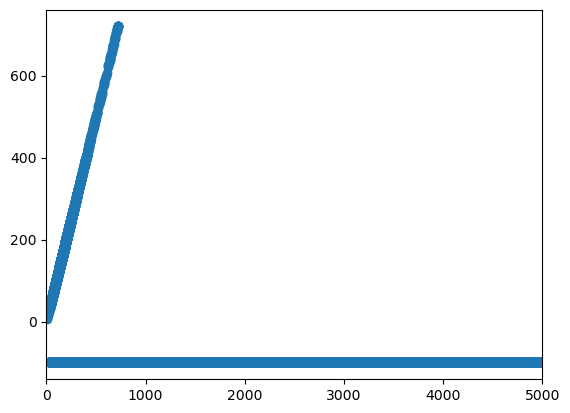

In [12]:
plt.scatter(data["onset_to_thrombolysis_time_surrogate"], data["onset_to_thrombolysis_time"])
plt.xlim(0,5000)

Get data for both models

In [13]:
data = data[selected_features_set]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [14]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [15]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [16]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features_set:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [17]:
feature_names_ohe = list(data)

Extract the team names

In [18]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

In [19]:
# replace the column name "stroke_team" with the ohe column names
selected_features_mrs.remove("stroke_team")
selected_features_mrs = selected_features_mrs + ohe_stroke_team_features

# replace the column name "stroke_team" with the ohe column names
selected_features_treatment.remove("stroke_team")
selected_features_treatment = selected_features_treatment + ohe_stroke_team_features

# Discharge disability multiclass model

In [20]:
data_mrs = data[selected_features_mrs]

In [21]:
feature_names_ohe = list(data_mrs)
feature_names_ohe.remove("discharge_disability")
n_features_ohe = len(feature_names_ohe)

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [22]:
X = data_mrs.drop('discharge_disability', axis=1)
y = data_mrs['discharge_disability']

## Fit XGBoost model multiclass classification model for discharge disability

Train model

In [23]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                (paths.notebook + paths.model_text + '.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model_outcome = pickle.load(filehandler)
else:
    # Define and Fit model
    model_outcome = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                            tree_method='gpu_hist')
    model_outcome.fit(X, y)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model_outcome, filehandler)

Setup the different X data for the scenarios


In [24]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(np.average(weighted_mrs),weighted_mrs)

In [25]:
mrs_classes = np.arange(7)

### Average population disability discharge (patient weighted outcome)
#### Scenario: Actual decision
Number treated

In [26]:
mask = X["onset_to_thrombolysis_time"]>-100
number_treated_actual = mask.sum()
number_treated_actual

34831

Patent weighted outcome (disability at discharge)

In [27]:
# Scenario actual decision

# Get and store predicted probabilities
y_probs = model_outcome.predict_proba(X)
(ave_weighted_mrs_actual, weighted_mrs_actual) = calculate_population_outcome(y_probs, mrs_classes)
ave_weighted_mrs_actual

2.6236414628157236

#### Scenario: Benchmark decision

Read in tthe 25 benchmark hospitals (identified in notebook 200)

In [28]:
filename = os.path.join(paths.data_save_path, 
    ('200_xgb_10_features_all_data_thrombolysis_decision_highest_25_benchmark_hospitals_median_shap.csv'))

benchmark_hospitals = pd.read_csv(filename)
benchmark_hospitals = list(benchmark_hospitals['hospital'])

In [29]:
# Open model to get thrombolysis treatment based on benchmark
# Model filename
filename_treatment_model = os.path.join(paths.model_save_path, 
                '200_xgb_10_features_all_data_thrombolysis_decision.p')

# Check if exists
file_exists = exists(filename_treatment_model)

if file_exists:
# Load models
    with open(filename_treatment_model, 'rb') as filehandler:
        model_treatment_decision = pickle.load(filehandler)
else:
    # give warning message
    print("Run notebook 200 to fit the treatment decision model")

In [30]:
# Get dataset for the treatment decision model
data_treatment_decision = data[selected_features_treatment]
X_treatment_decision = data_treatment_decision.drop('S2Thrombolysis', axis=1)

# For each benchmark hosptial, set all the patients as going there and get verdict
df_benchmark_decisions = pd.DataFrame()
for h in benchmark_hospitals:
    X_treatment_decision[ohe_stroke_team_features] = 0
    X_treatment_decision[f"team_{h}"] = 1
    df_benchmark_decisions[f"{h}"] = model_treatment_decision.predict(X_treatment_decision)

# Calculate the majority vote from the 25 benchmark hosptials
decision = df_benchmark_decisions.sum(axis=1)
decision = decision > (25/2)

In [31]:
X = data_mrs.drop('discharge_disability', axis=1)

mask = decision == 0
X["onset_to_thrombolysis_time"][mask] = -100

mask = decision == 1
X["onset_to_thrombolysis_time"][mask] = ott_default
number_treated_benchmark = mask.sum()
number_treated_benchmark

46486

In [32]:
# Get and store predicted probabilities
y_probs_benchmark = model_outcome.predict_proba(X)
(ave_weighted_mrs_benchmark, weighted_mrs_benchmark) = calculate_population_outcome(y_probs_benchmark, mrs_classes)
ave_weighted_mrs_benchmark

2.5740707613794047

In [33]:
# Scenario best decision

# Create X data for all treated
X_all_treated = data_mrs.drop('discharge_disability', axis=1)
mask = X_all_treated["onset_to_thrombolysis_time"] == -100
X_all_treated["onset_to_thrombolysis_time"][mask] = ott_default

# Get and store predicted probabilities
y_probs_treated = model_outcome.predict_proba(X_all_treated)
(ave_weighted_mrs_all_treated, weighted_mrs_all_treated) = calculate_population_outcome(y_probs_treated, mrs_classes)

# Create X data for none treated
X_none_treated = data_mrs.drop('discharge_disability', axis=1)
X_none_treated["onset_to_thrombolysis_time"] = -100

# Get and store predicted probabilities
y_probs_none_treated = model_outcome.predict_proba(X_none_treated)
(ave_weighted_mrs_none_treated, weighted_mrs_none_treated) = calculate_population_outcome(y_probs_none_treated, mrs_classes)

weighted_mrs_best = np.minimum(weighted_mrs_all_treated, weighted_mrs_none_treated)
mask = weighted_mrs_all_treated < weighted_mrs_none_treated
number_treated_best_treatment = mask.sum()
number_treated_best_treatment

148369

In [34]:
ave_weighted_mrs_best_treatment = np.average(weighted_mrs_best)
ave_weighted_mrs_best_treatment

2.424771524068329

Scenario all treated

In [35]:
mask = X_all_treated["onset_to_thrombolysis_time"] > -100
number_treated_all_treated = mask.sum()
number_treated_all_treated

168347

In [36]:
ave_weighted_mrs_all_treated

2.442576630646814

Scenario none treated

In [37]:
mask = X_none_treated["onset_to_thrombolysis_time"] > -100
number_treated_none_treated = mask.sum()
number_treated_none_treated

0

In [38]:
ave_weighted_mrs_none_treated

2.7038802875195196

Scenario worst decision

In [39]:
# Scenario worse decision

weighted_mrs_worst = np.maximum(weighted_mrs_all_treated, weighted_mrs_none_treated)
mask = weighted_mrs_all_treated > weighted_mrs_none_treated
number_treated_worst_treatment = mask.sum()
number_treated_worst_treatment

19852

In [40]:
ave_weighted_mrs_worst_treatment = np.average(weighted_mrs_worst)
ave_weighted_mrs_worst_treatment

2.7216853940980053

Collate results

In [41]:
mask = weighted_mrs_all_treated == weighted_mrs_none_treated
number_indifferent_outcome = mask.sum()

In [42]:
print(f"Scenario ACTUAL TREATMENT.\nNumber treated: {number_treated_actual}. Population outcome, mRS: {round(ave_weighted_mrs_actual,3)}")
print(f"\nScenario BENCHMARK DECISION.\nNumber treated: {number_treated_benchmark}. Population outcome, mRS: {round(ave_weighted_mrs_benchmark,3)}")
print(f"\nScenario BEST TREATMENT.\nNumber treated: {number_treated_best_treatment}. Population outcome, mRS: {round(ave_weighted_mrs_best_treatment,3)}")
print(f"\nScenario WORST TREATMENT.\nNumber treated: {number_treated_worst_treatment}. Population outcome, mRS: {round(ave_weighted_mrs_worst_treatment,3)}")
print(f"\n(Number of patients where treatment was indifferent for the outcome {number_indifferent_outcome})")
print(f"\nScenario ALL TREATED.\nNumber treated: {number_treated_all_treated}. Population outcome, mRS: {round(ave_weighted_mrs_all_treated,3)}")
print(f"\nScenario NONE TREATED.\nNumber treated: {number_treated_none_treated}. Population outcome, mRS: {round(ave_weighted_mrs_none_treated,3)}")

Scenario ACTUAL TREATMENT.
Number treated: 34831. Population outcome, mRS: 2.624

Scenario BENCHMARK DECISION.
Number treated: 46486. Population outcome, mRS: 2.574

Scenario BEST TREATMENT.
Number treated: 148369. Population outcome, mRS: 2.425

Scenario WORST TREATMENT.
Number treated: 19852. Population outcome, mRS: 2.722

(Number of patients where treatment was indifferent for the outcome 126)

Scenario ALL TREATED.
Number treated: 168347. Population outcome, mRS: 2.443

Scenario NONE TREATED.
Number treated: 0. Population outcome, mRS: 2.704


# KP YOU ARE HERE

Plot (want to create a subplot per patient, with the two mRS probability distributions on the same plot)

In [43]:
def create_df_for_bar_plot(df):
    df_bar  = pd.DataFrame()
    df_bar["Treatment"] = (["Treatment"] * 7) + (["No treatment"] * 7)
    df_bar["Discharge disability"] = np.append(df.index.values, df.index.values)
    df_bar["Probability"] = np.append(df["with"], df["without"])
    return(df_bar)

Get predictions for these patients, and store (\ dataframe for getting IVT, and a dataframe for not)

In [44]:
list_get_treatment = ["Treatment","No treatment"]
list_onset_to_thrombolysis_time = [ott_default, -100]

list_figures = []

for patient_loc in range(n_patients):

    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[0,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[0,:]

    # make first copy have, and the second copy not have thrombolysis treatment (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = list_onset_to_thrombolysis_time

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)

    df_patient_mrs_results = pd.DataFrame(
            data=y_probs, 
            columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"], 
            index=["with","without"])

    df_patient_mrs_results = df_patient_mrs_results.T

    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

#    ax = fig.add_subplot(n_patients, 1, patient_loc + 1)
    plotly_express_figure = px.bar(df_bar, x="Discharge disability", y="Probability", 
                color="Treatment", barmode="group")
    
    list_figures.append(plotly_express_figure)


fig = make_subplots(rows=len(list_figures), cols=1) 

for i, figure in enumerate(list_figures):
    for trace in range(len(figure["data"])):
        
        fig.append_trace(figure["data"][trace], row=i+1, col=1)

fig.update_layout(
    autosize=False,
    width=800,
    height=1600#,
#            title=f"{df_patient_prototypes.index.values[patient_loc]}",
#            xaxis_title="Discharge disability",
#            yaxis_title="Probability",
#            legend_title="Legend Title",
#            font=dict(
#                family="Courier New, monospace",
#                size=18,
#                color="RebeccaPurple"
#            )
)
#names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}

#fig.for_each_annotation(lambda a: a.update(text = df_patient_prototypes.index.values[patient_loc]))
         
fig.show()

#plot(fig)

NameError: name 'n_patients' is not defined

##### CELLS BELOW ARE CREATING A SINGLE FIGURE TO EXPERIMENT WITH THE PARAMETERS TO MAKE THE ABOVE SUBPLOT VERSION LOOK HOW WE WANT.

TO DO: 
1. Legend only have 1 entry per colour
1. Titles of the patient type for each subplot
1. X and Y axis labels

In [ ]:
list_get_treatment = ["Treatment","No treatment"]
list_onset_to_thrombolysis_time = [ott_default, -100]

# take details of this patient
df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), index=range(len(list_get_treatment)))

# take exact copy of row
df_patient_details.iloc[0] = df_patient_prototypes.iloc[0,:]
df_patient_details.iloc[1] = df_patient_prototypes.iloc[0,:]

# make first copy have, and the second copy not have thrombolysis treatment (either not get, or get at 2 hours)
df_patient_details["onset_to_thrombolysis_time"] = list_onset_to_thrombolysis_time

df_patient_details = df_patient_details.astype('float')

df_patient_details


In [ ]:
y_probs = model.predict_proba(df_patient_details)
y_pred = model.predict(df_patient_details)

In [ ]:
df_patient_mrs_results = pd.DataFrame(
            data=y_probs, 
            columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"], 
            index=["with","without"])

In [ ]:
df_patient_mrs_results = df_patient_mrs_results.T
df_patient_mrs_results

In [ ]:
df_bar = create_df_for_bar_plot(df_patient_mrs_results)
df_bar

In [ ]:
px.bar(df_bar, x="Discharge disability", y="Probability", 
                color="Treatment", barmode="group")# title=f"{df_patient_details.index.value}")